In [ ]:
import pandas as pd
df = pd.read_csv("/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_0/process_data_pos_0_14.csv")
df.head(3)


,Texto,Polaridade,Len_txt,Vetores
0,"['000inr', 'wow', 'business', 'sir', 'ji', 'me...",1,19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1,"['000views', 'earth', 'people', 'drinking', 'w...",1,10,"[0, 0, 0, 0, 20, 21, 22, 23, 24, 25, 26, 27, 2..."
2,"['00am', 'july', 'active', 'confirmed', 'cases...",1,19,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4..."


In [11]:
import pandas as pd
import glob
import os

# Base folder that contains the three subfolders
base_dir = "/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets"

# Collect all CSVs from the three subfolders
csv_files = glob.glob(os.path.join(base_dir, "process_data_*", "*.csv"))
print(f"Found {len(csv_files)} CSV files:", csv_files)

# Read and combine them
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add which folder/file it came from
    df["source_file"] = os.path.basename(file)
    dfs.append(df)

# Concatenate all datasets into one
combined_df = pd.concat(dfs, ignore_index=True)

# Add readable text column (join tokenized words)
combined_df["text"] = combined_df["Texto"].apply(lambda x: " ".join(eval(x)) if isinstance(x, str) else "")

# Add human-readable sentiment label
combined_df["Sentiment_Label"] = combined_df["Polaridade"].apply(lambda x: "Positive" if x == 1 else "Negative")

# Keep relevant columns
final_df = combined_df[["text", "Sentiment_Label", "Len_txt", "Vetores"]]

# Save the merged dataset
output_path = os.path.join(base_dir, "covid_combined_dataset.csv")
final_df.to_csv(output_path, index=False)

print(f"Combined dataset saved to: {output_path}")
print(f"Total tweets combined: {len(final_df)}")


Found 6 CSV files: ['/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_2/process_data_pos_2_12.csv', '/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_2/process_data_neg_2_12.csv', '/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_1/process_data_pos_1_13.csv', '/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_1/process_data_neg_1_13.csv', '/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_0/process_data_pos_0_14.csv', '/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/process_data_0/process_data_neg_0_14.csv']
Combined dataset saved to: /Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/covid_combined_dataset.csv
Total tweets combined: 400000


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salarian.1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loaded dataset with 400000 tweets
NRC VAD lexicon loaded. Sample:
[('a battery', {'Valence': 0.134, 'Arousal': -0.298, 'Dominance': -0.096}), ('a bit', {'Valence': -0.096, 'Arousal': -0.264, 'Dominance': -0.214}), ('a bunch', {'Valence': 0.088, 'Arousal': -0.35, 'Dominance': -0.068}), ('a cappella', {'Valence': 0.134, 'Arousal': -0.116, 'Dominance': -0.2}), ('a couple', {'Valence': 0.266, 'Arousal': -0.11, 'Dominance': 0.09})]


Computing valence, arousal, dominance: 100%|██████████| 400000/400000 [00:06<00:00, 61654.10it/s]


Saved with emotion scores: /Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/covid_combined_dataset_with_VAD_Dominance.csv

Mean valence/arousal/dominance by sentiment:
                 valence_mean  arousal_mean  dominance_mean
Sentiment_Label                                            
Negative               -0.017        -0.000          -0.013
Positive                0.200        -0.026           0.102


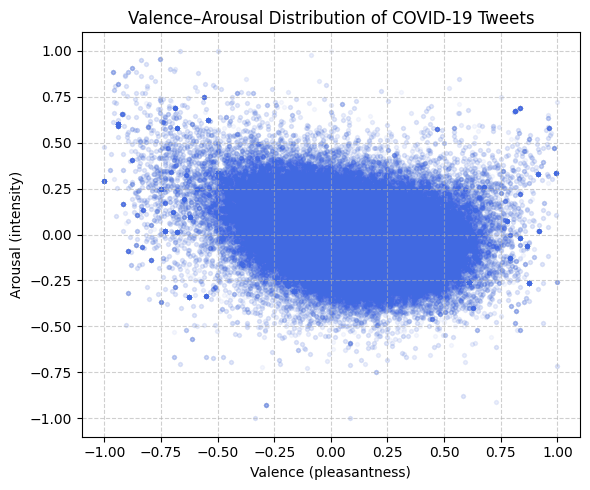

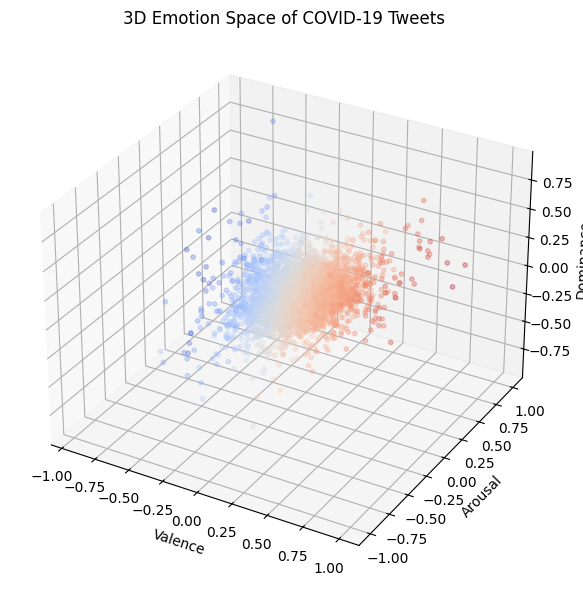

In [12]:
# ================================================================
# Emotion Analysis on COVID-19 Tweets using NRC VAD Lexicon
# ================================================================

import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------------------------------------
# 1. Setup and Load Data
# ------------------------------------------------------------
nltk.download("punkt")

data_path = "/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/covid_combined_dataset.csv"
vad_path = "/Users/salarian.1/Documents/files/courses/NLP/FinalProject/NRC-VAD-Lexicon-v2.1/NRC-VAD-Lexicon-v2.1.txt"

# Load tweet dataset
df = pd.read_csv(data_path)
print(f"Loaded dataset with {len(df)} tweets")

# ------------------------------------------------------------
# 2. Load and Prepare NRC VAD Lexicon
# ------------------------------------------------------------
vad_df = pd.read_csv(vad_path, sep="\t")

vad_df.rename(columns={
    "term": "Word",
    "valence": "Valence",
    "arousal": "Arousal",
    "dominance": "Dominance"
}, inplace=True)

vad_dict = vad_df.set_index("Word").to_dict(orient="index")
print("NRC VAD lexicon loaded. Sample:")
print(list(vad_dict.items())[:5])

# ------------------------------------------------------------
# 3. Compute Valence, Arousal, and Dominance per Tweet
# ------------------------------------------------------------
def compute_vad_scores(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return (np.nan, np.nan, np.nan)

    # clean text: lowercase, remove punctuation/numbers
    text = re.sub(r"[^a-zA-Z\s]", " ", text.lower())
    tokens = text.split()

    vals, aros, doms = [], [], []
    for t in tokens:
        if t in vad_dict:
            vals.append(vad_dict[t]["Valence"])
            aros.append(vad_dict[t]["Arousal"])
            doms.append(vad_dict[t]["Dominance"])

    if len(vals) == 0:
        return (np.nan, np.nan, np.nan)

    return (np.mean(vals), np.mean(aros), np.mean(doms))

# ------------------------------------------------------------
# 4. Apply to All Tweets
# ------------------------------------------------------------
tqdm.pandas(desc="Computing valence, arousal, dominance")
df[["valence_mean", "arousal_mean", "dominance_mean"]] = (
    df["text"].progress_apply(compute_vad_scores).apply(pd.Series)
)

# ------------------------------------------------------------
# 5. Save Updated Dataset
# ------------------------------------------------------------
output_path = data_path.replace(".csv", "_with_VAD_Dominance.csv")
df.to_csv(output_path, index=False)
print(f"Saved with emotion scores: {output_path}")

# ------------------------------------------------------------
# 6. Summary Statistics
# ------------------------------------------------------------
print("\nMean valence/arousal/dominance by sentiment:")
summary = (
    df.groupby("Sentiment_Label")[["valence_mean", "arousal_mean", "dominance_mean"]]
    .mean()
    .round(3)
)
print(summary)

# ------------------------------------------------------------
# 7. 2D Scatter: Valence vs. Arousal
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.scatter(df["valence_mean"], df["arousal_mean"], alpha=0.05, s=8, color="royalblue")
plt.title("Valence–Arousal Distribution of COVID-19 Tweets")
plt.xlabel("Valence (pleasantness)")
plt.ylabel("Arousal (intensity)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/VAD_scatter.png", dpi=300)
plt.show()

# ------------------------------------------------------------
# 8. 3D Visualization: Valence–Arousal–Dominance
# ------------------------------------------------------------
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
sample_df = df.dropna(subset=["valence_mean", "arousal_mean", "dominance_mean"]).sample(5000)
ax.scatter(
    sample_df["valence_mean"],
    sample_df["arousal_mean"],
    sample_df["dominance_mean"],
    c=sample_df["valence_mean"], cmap="coolwarm", alpha=0.3, s=10
)
ax.set_xlabel("Valence")
ax.set_ylabel("Arousal")
ax.set_zlabel("Dominance")
ax.set_title("3D Emotion Space of COVID-19 Tweets")
plt.tight_layout()
plt.savefig("/Users/salarian.1/Documents/files/courses/NLP/FinalProject/result/VAD_3D.png", dpi=300)
plt.show()


Low valence threshold: -0.075
High arousal threshold: 0.095

Extreme emotion frequency by sentiment:
  Sentiment_Label  Extreme_Ratio
0        Negative          42.89
1        Positive          20.81


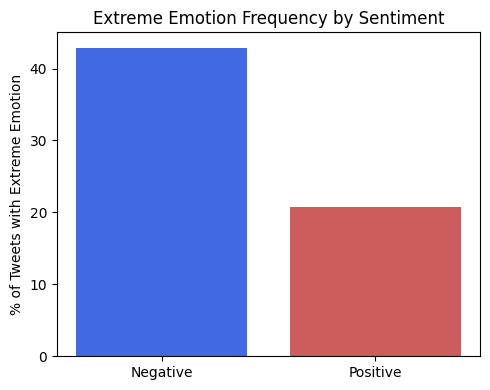

In [5]:
import pandas as pd

# Load the dataset with VAD scores
df = pd.read_csv("/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/covid_combined_dataset_with_VAD_Dominance.csv")

# Drop rows with missing VAD values
df = df.dropna(subset=["valence_mean", "arousal_mean"])

# Define thresholds
low_valence_thresh = df["valence_mean"].quantile(0.2)
high_arousal_thresh = df["arousal_mean"].quantile(0.8)

print(f"Low valence threshold: {low_valence_thresh:.3f}")
print(f"High arousal threshold: {high_arousal_thresh:.3f}")

# Label extreme tweets
df["extreme_emotion"] = (
    (df["valence_mean"] <= low_valence_thresh) | 
    (df["arousal_mean"] >= high_arousal_thresh)
)

# Compute share of extreme tweets by sentiment
summary = (
    df.groupby("Sentiment_Label")["extreme_emotion"]
    .mean()
    .reset_index()
    .rename(columns={"extreme_emotion": "Extreme_Ratio"})
)
summary["Extreme_Ratio"] = (summary["Extreme_Ratio"] * 100).round(2)

print("\nExtreme emotion frequency by sentiment:")
print(summary)

# Optional: plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.bar(summary["Sentiment_Label"], summary["Extreme_Ratio"], color=["royalblue", "indianred"])
plt.ylabel("% of Tweets with Extreme Emotion")
plt.title("Extreme Emotion Frequency by Sentiment")
plt.tight_layout()
plt.savefig("/Users/salarian.1/Documents/files/courses/NLP/FinalProject/result/extreme_emotion_by_sentiment.png", dpi=300)
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

# Paths
data_path = "/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/covid_combined_dataset_with_VAD_Dominance.csv"
df = pd.read_csv(data_path).dropna(subset=["text"])

# Load RoBERTa Twitter sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

labels = ['negative','neutral','positive']

# Prediction function
def roberta_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()[0]
    pred_label = labels[np.argmax(probs)]
    valence = probs[2] - probs[0]   # positive minus negative prob as valence proxy
    return pd.Series([pred_label, valence, probs[0], probs[1], probs[2]])

# Apply to sample subset (to save time, 10k tweets)
sample = df.sample(10000, random_state=42)
tqdm.pandas(desc="RoBERTa predictions")
sample[["roberta_label","roberta_valence","prob_neg","prob_neu","prob_pos"]] = sample["text"].progress_apply(roberta_sentiment)

# Merge back and save
merged = sample.merge(df[["text","valence_mean","arousal_mean","dominance_mean","Sentiment_Label"]], on="text", how="left")
merged.to_csv("/Users/salarian.1/Documents/files/courses/NLP/FinalProject/tweets_datasets/covid_sample_roberta_comparison.csv", index=False)
print("Saved comparison file.")


/Users/salarian.1/miniconda3/envs/llm/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

✅ Saved comparison file.


In [ ]:
corr = merged[["roberta_valence", "valence_mean_x"]].corr().iloc[0, 1]
print(f"Correlation between RoBERTa and NRC valence: {corr:.3f}")


Correlation between RoBERTa and NRC valence: 0.629


In [ ]:
pd.crosstab(
    merged["roberta_label"],
    merged["Sentiment_Label_x"],
    normalize="columns"
).round(2)


Sentiment_Label_x,Negative,Positive
roberta_label,,
negative,0.77,0.26
neutral,0.22,0.47
positive,0.01,0.27


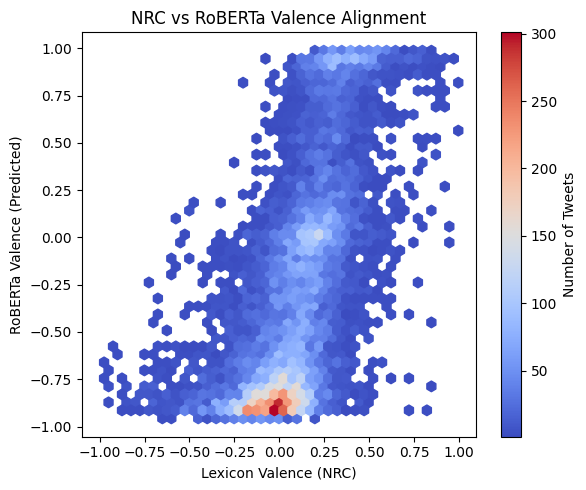

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.hexbin(
    merged["valence_mean_x"],   # NRC valence
    merged["roberta_valence"],  # RoBERTa valence
    gridsize=40,
    cmap="coolwarm",
    mincnt=1
)
plt.xlabel("Lexicon Valence (NRC)")
plt.ylabel("RoBERTa Valence (Predicted)")
plt.title("NRC vs RoBERTa Valence Alignment")
cb = plt.colorbar()
cb.set_label("Number of Tweets")
plt.tight_layout()
plt.show()
